In [1]:
import pandas as pd

In [2]:
train_csv_file_path = '../DataSet/DataAfterEda/train.csv'
test_csv_file_path = '../DataSet/DataAfterEda//test.csv'

In [3]:
train = pd.read_csv(train_csv_file_path)
test = pd.read_csv(test_csv_file_path)

In [4]:
y_train = train['target']
x_train = train.drop(columns=['target'])

In [5]:
y_test = test['target']
x_test = test.drop(columns=['target'])

# Word2Vec

In [6]:
import pickle
from tqdm import tqdm
import numpy as np

In [7]:
# make sure you have the glove_vectors file
with open('../DataSet/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [8]:
X_train_text_avg_w2v_vectors = []
for sentence in tqdm(x_train['clean_text']): 
    vector = np.zeros(300) 
    cnt_words =0; 
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_train_text_avg_w2v_vectors.append(vector)

print(len(X_train_text_avg_w2v_vectors))
print(len(X_train_text_avg_w2v_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 7613/7613 [00:00<00:00, 16720.66it/s]

7613
300


In [9]:
X_test_text_avg_w2v_vectors = []
for sentence in tqdm(x_test['clean_text']): 
    vector = np.zeros(300) 
    cnt_words =0; 
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_test_text_avg_w2v_vectors.append(vector)

print(len(X_test_text_avg_w2v_vectors))
print(len(X_test_text_avg_w2v_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 3263/3263 [00:00<00:00, 41740.54it/s]

3263
300


# LinearSVC

In [10]:
from scipy.sparse import hstack

In [12]:
# X_tr = hstack((X_train_text_avg_w2v_vectors)).tocsr()
# X_te = hstack((X_test_text_avg_w2v_vectors)).tocsr()

C:\Users\user\Anaconda3\envs\Learning\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


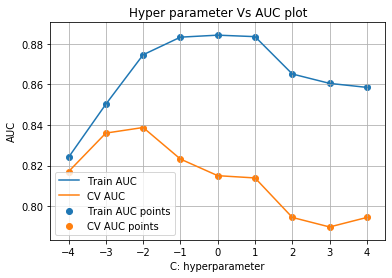

In [17]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

SVC = LinearSVC(class_weight= "balanced")
parameters = {'C':[10**x for x in range(-4,5,1)]} 
clf = RandomizedSearchCV(SVM, parameters, cv=10, scoring='roc_auc', n_jobs=-1, return_train_score =True)
clf.fit(X_train_text_avg_w2v_vectors, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_C'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
C =  results['param_C']

plt.plot(np.log10(C.astype(float)), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log10(C.astype(float)), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(np.log10(C.astype(float)), train_auc, label='Train AUC points')
plt.scatter(np.log10(C.astype(float)), cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

In [35]:
best_C = 1

In [20]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

C:\Users\user\Anaconda3\envs\Learning\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\user\Anaconda3\envs\Learning\lib\site-packages\sklearn\metrics\_ranking.py:788: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


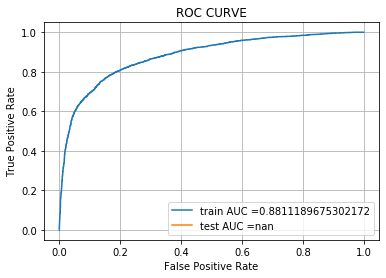

In [36]:
from sklearn.metrics import roc_curve, auc

SVC = LinearSVC(class_weight= "balanced", C=best_C)
SVC.fit(X_train_text_avg_w2v_vectors, y_train)

y_train_pred = SVC.decision_function(X_train_text_avg_w2v_vectors)
y_test_pred = SVC.decision_function(X_test_text_avg_w2v_vectors)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC CURVE")
plt.grid()
plt.show()

In [37]:
y_test_prediction = SVC.predict(X_test_text_avg_w2v_vectors)

In [38]:
submission = pd.DataFrame({"id": test["id"],"target": y_test_prediction})
filename = 'submission.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

Saved file: submission.csv
